In [50]:
# import libraries
library(tidyverse)
library(caret)
library(corrplot)
library(reshape2)
library(gridExtra)
library(leaps)
library('ggpubr')
library(car)

Warning message:
"package 'car' was built under R version 4.3.3"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 4.3.3"

Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 'package:purrr':

    some




# Data

In [2]:
# read in dataset
# from https://www.kaggle.com/datasets/wduckett/moneyball-mlb-stats-19622012
df <- read_csv('data/baseball.csv')

Rows: 1232 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Team, League
dbl (13): Year, RS, RA, W, OBP, SLG, BA, Playoffs, RankSeason, RankPlayoffs,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Functions

In [49]:
diagnostics_plots <- function(df, model, response_var, type='linear') {
    # default plots
    plot(model)
    
    # if linear
    if (type=='linear') {
        plot(predict(model), df[[response_var]])
    # if response
    } else  if (type=='response') {
        plot(predict(model, type='response'), df[[response_var]])
    } else {
        print('Please use either type: linear or type: response')
    }
    
    
    # successive residuals
    df_diagnostics = data.frame(yhat = fitted(model), r = resid(model), y = df[[response_var]])

    n = dim(df)[1]; 
    x = head(df_diagnostics$r, n-1)
    y = tail(df_diagnostics$r, n-1)
    srp = data.frame(x,y)
    ggplot(srp, aes(x = x, y = y)) + 
        geom_point() + 
        geom_vline(xintercept = 0) + 
        geom_hline(yintercept = 0) + 
        xlab(expression(hat(epsilon)[i])) +
        ylab(expression(hat(epsilon)[i+1])) + 
        ggtitle("Successive Residual Plot") + 
        theme_bw() + 
        theme(plot.title = element_text(hjust = 0.5)) 
    }

# Concept

# The Pythagorean Theorem of Baseball

Let

$R_s$: Runs Scored

$R_a$: Runs Allowed

$W_p$: Winning Percentage

Then, there were two formulas presented:

The more *common*:

$W_p = \frac{R_s^2}{R_s^2 + R_a^2}$

The more *accurate*:

$W_p = \frac{R_s^{1.81}}{R_s^{1.81} + R_a^{1.81}}$

---

Our goal is to find some factor, $f$, such that:

$$W_p = \frac{R_s^f}{R_s^f + R_a^f}$$

---

For ease, let's assign 

- $R_s = s$
- $R_a = a$
- $W_p = p$

$W_p = \frac{R_s^f}{R_s^f + R_a^f}$

$\rightarrow p = \frac{s^f}{s^f + a^f}$

$(s^f + a^f) p = \frac{s^f}{s^f + a^f} (s^f + a^f)$

$(s^f + a^f)p = s^f$

$s^fp + a^fp = s^f$

$a^fp = s^f - s^fp$

$a^fp = s^f(1 - p)$

$\frac{p}{1 - p} = \frac{s^f}{a^f}$

$\log(\frac{p}{1 - p}) = \log(\frac{s^f}{a^f})$

$\log(\frac{p}{1 - p}) = f\log(\frac{s}{a})$

---

So what this means for our dataset and model is that we can transform our columns into:

- $y = \log(\frac{W_p}{1-W_p})$: response variable
- $x = \log(\frac{R_s}{R_a})$: predictor variable

By using simple linear regression, we can create a model where

$y = \beta_0 + \beta_1 x$,

If the **Pythagorean Theorem of Baseball** holds weight, then we would roughly expect

$\beta_0$ to be close to $0$ and $\beta_1$ near the range $(1.81, 2)$, from:

The more *common*:

$W_p = \frac{R_s^2}{R_s^2 + R_a^2}$

The more *accurate*:

$W_p = \frac{R_s^{1.81}}{R_s^{1.81} + R_a^{1.81}}$

# Clean Data

In [3]:
# select the necessary columns
df_theorem <- df %>% select(c(RS, RA, W, G))
# create win percentage
df_theorem$WP <- with(df_theorem, W/G)
# drop columns used in the win percentage column
df_theorem <- df_theorem %>% select(-c(W, G))
# create the response column
df_theorem$response <- with(df_theorem, log(WP/(1-WP)))
# create the predictor column
df_theorem$predictor <- with(df_theorem, log(RS/RA))
# head(df_theorem)

# Model Selection

In [4]:
lmod <- lm(data=df_theorem, response ~ predictor)

In [15]:
summary(lmod)
confint(lmod, level=0.95)


Call:
lm(formula = response ~ predictor, data = df_theorem)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36456 -0.06840  0.00013  0.06704  0.31094 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.002198   0.002828  -0.777    0.437    
predictor    1.870947   0.019587  95.519   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09926 on 1230 degrees of freedom
Multiple R-squared:  0.8812,	Adjusted R-squared:  0.8811 
F-statistic:  9124 on 1 and 1230 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
(Intercept),-0.007745589,0.003350158
predictor,1.832519044,1.909375372


# Commentary

Our factor was in the right range, let's compare the 3 formulas to the actual win percentage. We'll also examine the model itself through the metric `R2: formula_6` ($R^2$).

*Note that we've only used the coefficient from the model for the plotting. The actual regression formula would include the intercept, but that was not the point of this experiment. We'll discuss the actual model performance below the plotting.*

In [8]:
# create comparison 
derived_factor <- unname(lmod$coefficients[2])
df_theorem$derived <- with(df_theorem, RS^derived_factor / (RS^derived_factor + RA^derived_factor))
df_theorem$common <- with(df_theorem, RS^2 / (RS^2 + RA^2))
df_theorem$accurate <- with(df_theorem, RS^1.81 / (RS^1.81 + RA^1.81))

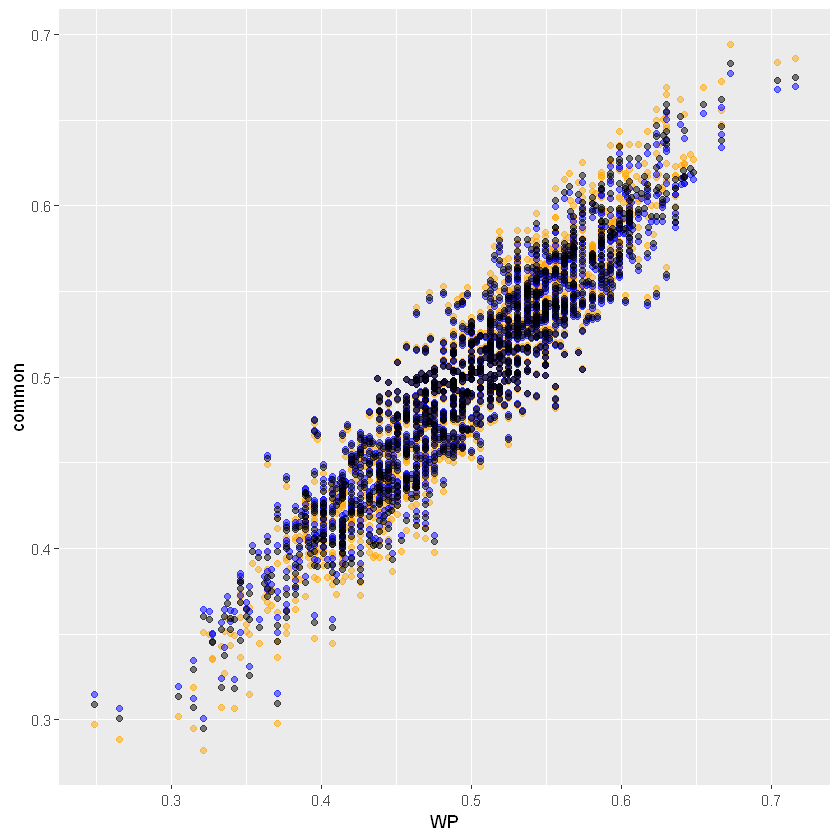

In [13]:
ggplot(df_theorem) +
    geom_point(aes(WP, y=common), color='orange', alpha=0.5) +
    geom_point(aes(WP, y=accurate), color='blue', alpha=0.5) +
    geom_point(aes(WP, y=derived), alpha=0.5)

Since this is a simple linear regression (single feature), we can confidently use the p-values from the t-tests and the $R^2$ metric to analyze the model itself.

We'll first note that the p-value associated with the intercept is $0.437$. Since this is the p-value associated with the t-test, using our standard significance level of $\alpha=0.05$, we don't have enough evidence to reject the null hypothesis that $\beta_0 = 0$. Therefore, there is some not enough statistical evidence that the intercept has an effect on the response variables (i.e. it may be equivalent to $0$), which is what we were expecting.

Next, noticing the $R^2$ value of $0.8812$, this tells us that the model explains approximately $88\%$ of variance in the data.

Overall, this indicates that the **Pythagorean Theorem of Baseball** does hold weight!

# Diagnostics

## Plots

- Residuals vs. Fitted (constant variance assumption)
- QQ-Plot (normality assumption)
- Residuals vs. Leverage (outliers)
- Predicted vs. Observed (linearity assumption)
- Successive Residual Plot (independence assumption)

## Hypothesis Tests

- Shapiro-Wilk Normality Test (normality assumption)
- Durbin-Watson Test (autocorrelation of residuals - independence assumption)

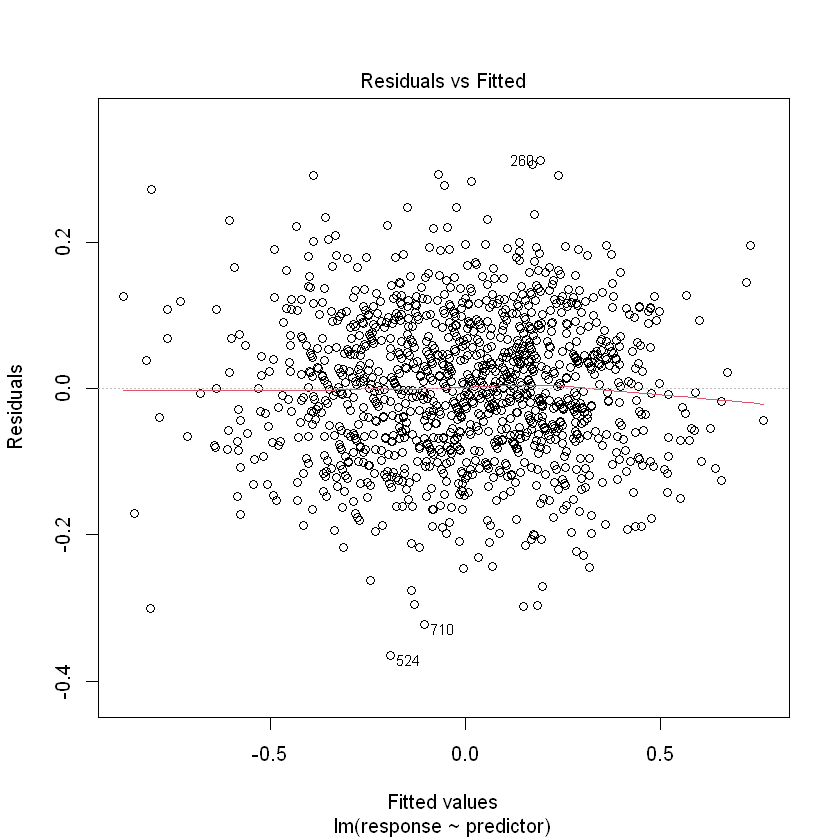

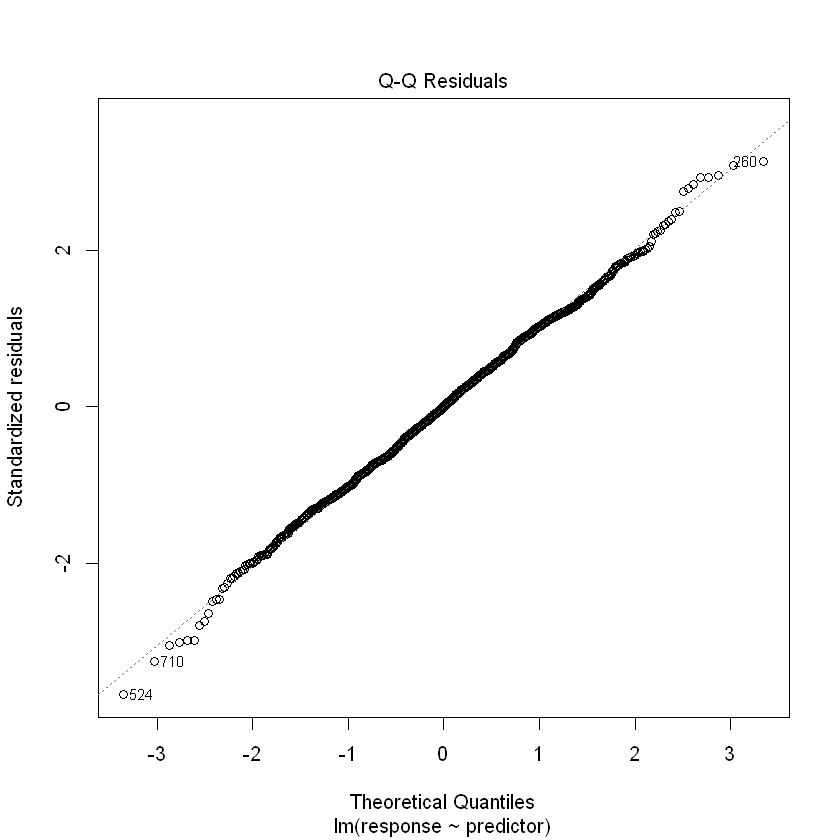

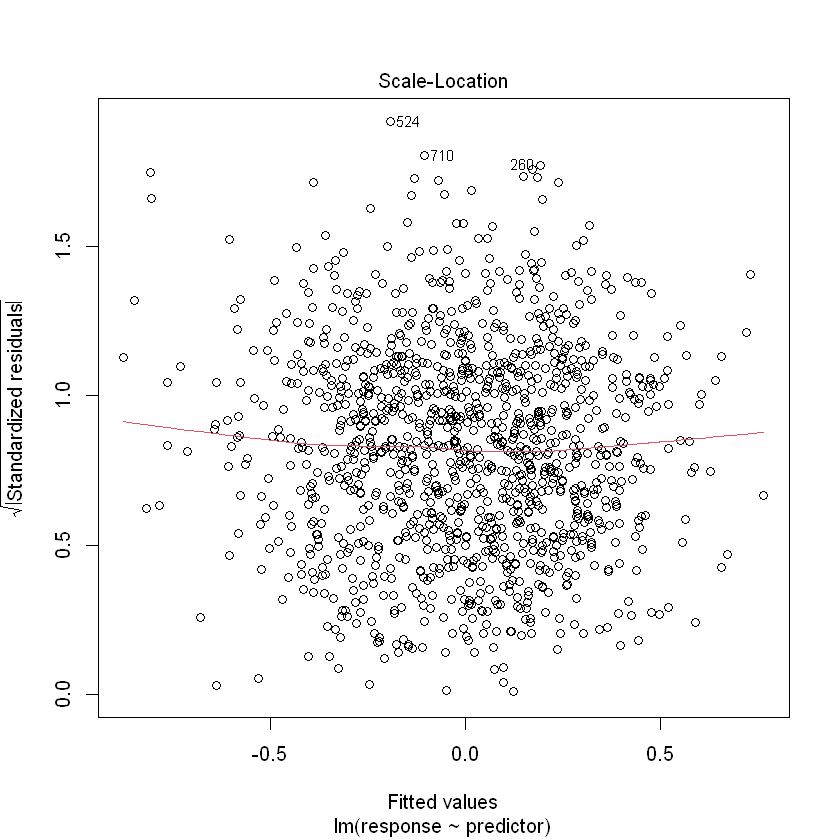

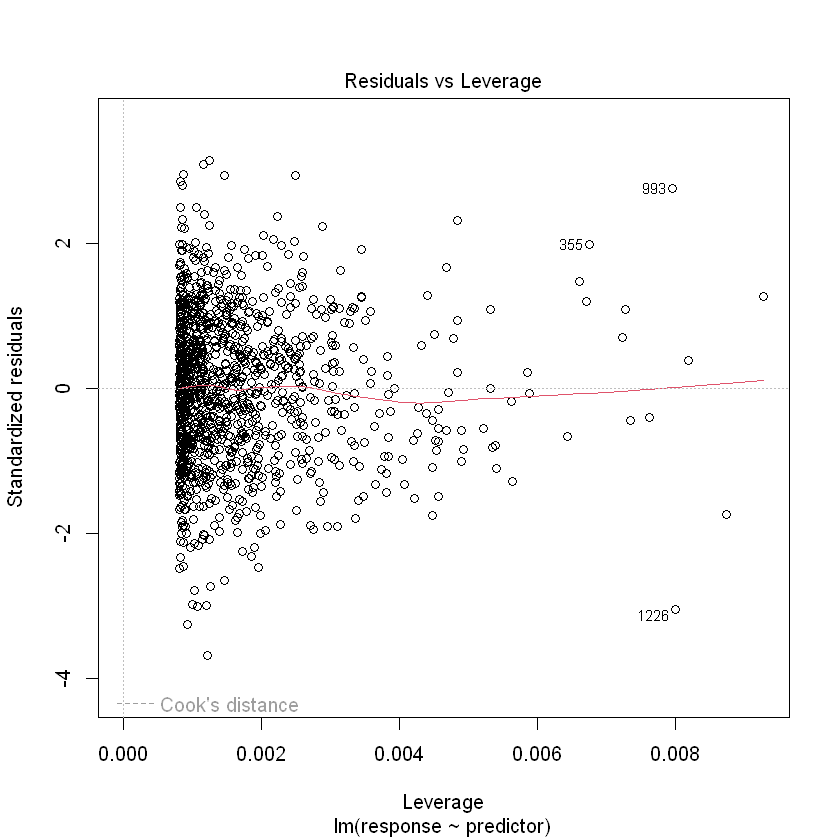

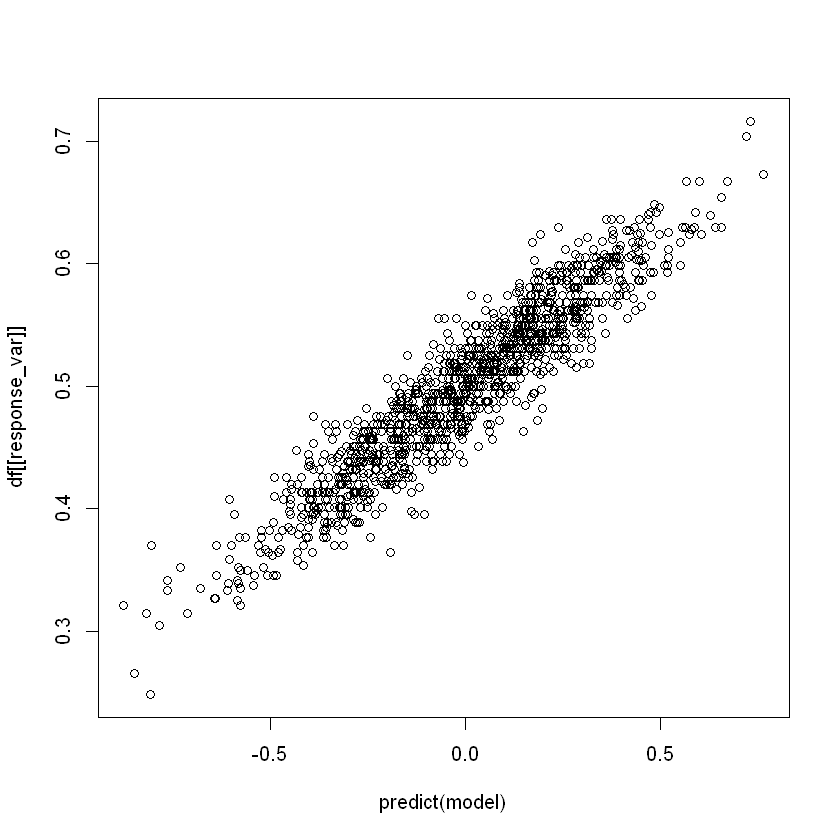

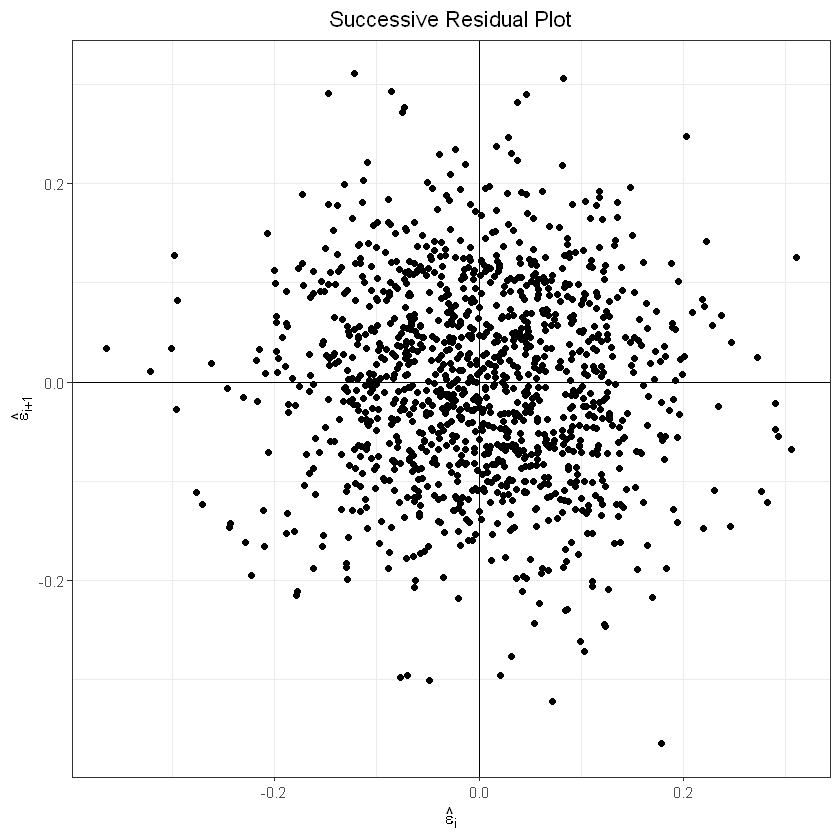

In [48]:
# plots
diagnostics_plots(df=df_theorem, model=lmod, response_var='WP', type='linear')

# Comments on Diagnostic Plots